### Adversarial-Robustness-Toolbox for LightGBM. This notebook shows how to use ART with LightGBM models. It demonstrates and analyzes Zeroth Order Optimisation attacks using `Fraud-Detection Model.`

* The goal of the Adverserial Attack on Machine learning model/Deep Learning Model is simply to make the target model misclassify by predicting the adversarial example, I, as a class, other than the original class, X. This is usually done by adding noise to the training examples so that the model misclassify.

* This notebook show how to generates the adversarial training data using Adversarial-Robustness-Toolbox. This will prepare the model against adversarial attacks so it doesn't misclassify and is able to distinguish noise from the real data. 

#### Install the Necessary Libraries 

In [1]:
#!pip install adversarial-robustness-toolbox

In [2]:
#!pip install pandas_profiling

In [3]:
#!pip install lightgbm

## The Notebook contains the following steps:

Using the `Fraud-Predict-Data`, we will do
  * Exploratory Data Analysis
  * Build Lightgbm model.
  * `Generate Adversarial examples`
  * Feature importance. 
  * interpreting the model attributes using Shap for improving the accuracy.

In [4]:
import lightgbm as lgb

# from sklearn.datasets import load_iris

import numpy as np
from matplotlib import pyplot as plt

from art.estimators.classification import LightGBMClassifier
from art.attacks.evasion import ZooAttack
from art.utils import load_mnist

import warnings
warnings.filterwarnings('ignore')


In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import ipaddress
import pandas_profiling as pp
%matplotlib inline
from sklearn import preprocessing
plt.rc("font", size=14)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings("ignore")
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMClassifier
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

### Load the `Fraud-Data` as csv in the notebook. 

* Click on the `0100` on the top right corner. 
* Drag and Drop `Fraud-Data.csv` 
* Select the Cell below. 
* Click on `Insert to Code` and then `Pandas Dataframe.`
* Name the Dataframe as `df`



In [6]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_6f36c7b669bf4bb58c56051ea1508b9b = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='Cw2eSp0GZkC_r4hg3l-sZCm_96xjGMJcro-qe7YTX4LN',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_6f36c7b669bf4bb58c56051ea1508b9b.get_object(Bucket='fraudpredictionampaiexplainablity-donotdelete-pr-m8jztpooxxxpcj',Key='fraud_dataset.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Term,Credit_History_Available,Housing,Locality,Fraud_Risk
0,1,0,0,1,0,5849,0,146,360,1,1,1,0
1,1,1,1,1,1,4583,1508,128,360,1,1,3,1
2,1,1,0,1,1,3000,0,66,360,1,1,1,1
3,1,1,0,0,1,2583,2358,120,360,1,1,1,1
4,1,0,0,1,0,6000,0,141,360,1,1,1,0


In [7]:
pp.ProfileReport(df)

We can observe that there are no missing values and no duplicates. We can do detailed analysis of each attribute to understand the data better. 

In [8]:
count_fraud = len(df[df['Fraud_Risk']==0])
count_non_fraud = len(df[df['Fraud_Risk']==1])
pct_of_non_fraud = count_non_fraud/(count_non_fraud +count_fraud)
print("percentage of non Fraud Risk is", round(pct_of_non_fraud*100,2))
pct_of_fraud = count_fraud/(count_non_fraud +count_fraud)
print("percentage of Fraud Risk", round(pct_of_fraud*100,2))

percentage of non Fraud Risk is 57.68
percentage of Fraud Risk 42.32


Plot the target attribute

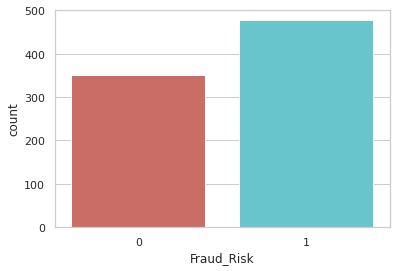

In [9]:
sns.countplot(x='Fraud_Risk',data=df, palette='hls')
plt.show()

In [10]:
df.groupby('Fraud_Risk').mean()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Term,Credit_History_Available,Housing,Locality
Fraud_Risk,,,,,,,,,,,,
0,0.574286,0.000000,0.308571,0.808571,0.177143,4779.974286,1092.642857,125.611429,346.685714,0.974286,0.700000,2.005714
1,0.851153,0.834382,0.905660,0.777778,0.865828,5530.683438,1774.714885,152.104822,331.849057,0.819706,0.620545,1.958071


In [11]:
df.corr(method ='pearson') 

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Term,Credit_History_Available,Housing,Locality,Fraud_Risk
Gender,1.000000,0.355319,0.121868,-0.080883,0.256583,0.010382,0.116468,0.089613,-0.074194,-0.019499,-0.006226,-0.002798,0.309570
Married,0.355319,1.000000,0.375512,-0.034168,0.829158,0.071710,0.106108,0.175254,-0.108588,-0.085615,-0.093419,-0.019892,0.825064
Dependents,0.121868,0.375512,1.000000,-0.025549,0.349978,0.130331,0.026961,0.182559,-0.050031,-0.085019,-0.022433,-0.012152,0.315421
Education,-0.080883,-0.034168,-0.025549,1.000000,-0.027868,0.127969,0.050707,0.154714,0.109241,0.057124,0.001073,-0.103206,-0.037406
Self_Employed,0.256583,0.829158,0.349978,-0.027868,1.000000,0.138274,0.078241,0.229533,-0.104434,-0.049356,-0.106595,-0.049677,0.688170
ApplicantIncome,0.010382,0.071710,0.130331,0.127969,0.138274,1.000000,-0.120363,0.564923,-0.004199,-0.022038,-0.049480,-0.018499,0.066347
CoapplicantIncome,0.116468,0.106108,0.026961,0.050707,0.078241,-0.120363,1.000000,0.165940,-0.054756,-0.035843,-0.018713,0.003190,0.120304
LoanAmount,0.089613,0.175254,0.182559,0.154714,0.229533,0.564923,0.165940,1.000000,0.073583,-0.024920,-0.084477,0.022021,0.164087
Loan_Term,-0.074194,-0.108588,-0.050031,0.109241,-0.104434,-0.004199,-0.054756,0.073583,1.000000,0.076045,0.026219,0.084809,-0.097339
Credit_History_Available,-0.019499,-0.085615,-0.085019,0.057124,-0.049356,-0.022038,-0.035843,-0.024920,0.076045,1.000000,0.017112,-0.005251,-0.239512


We can observe strong positive co-relation between the attributes Married & Self Employed to the target variable which is Fraud Risk.

### Select input and target variables

In [16]:
X = df[df.columns[0:12]]
y = df[df.columns[12:]]

In [17]:
y

,Fraud_Risk
0,0
1,1
2,1
3,1
4,0
...,...
822,0
823,0
824,0
825,0


In [18]:
df.dtypes

Gender                      int64
Married                     int64
Dependents                  int64
Education                   int64
Self_Employed               int64
ApplicantIncome             int64
CoapplicantIncome           int64
LoanAmount                  int64
Loan_Term                   int64
Credit_History_Available    int64
Housing                     int64
Locality                    int64
Fraud_Risk                  int64
dtype: object

We can observe that all the attributes are in Int data type.

Check for null values

In [63]:
df.isna()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Term,Credit_History_Available,Housing,Locality,Fraud_Risk
0,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,False,False,False,False,False,False,False,False,False,False,False,False,False
823,False,False,False,False,False,False,False,False,False,False,False,False,False
824,False,False,False,False,False,False,False,False,False,False,False,False,False
825,False,False,False,False,False,False,False,False,False,False,False,False,False


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

### Splitting the data with 70:30 mix

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [21]:
y_train

,Fraud_Risk
127,0
452,1
762,0
817,0
453,1
...,...
763,0
192,1
629,0
559,1


In [23]:
# X_train = np.argmax(X, axis=1)
# X_train

In [27]:
# np.argmax(y_train.values.ravel(),axis=1)
y_train.values.ravel()

array([0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,

In [33]:
print("Train_x Shape :: ", X_train.shape)
print("Train_y Shape :: ", y_train.shape)
print("Test_x Shape :: ", X_test.shape)
print("Test_y Shape :: ", y_test.shape)

Train_x Shape ::  (578, 12)
Train_y Shape ::  (578, 1)
Test_x Shape ::  (249, 12)
Test_y Shape ::  (249, 1)


In [35]:
# Create and fit LightGBM model
num_round = 10
param = {'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 2}
train_data = lgb.Dataset(X_train, label=y_train)
model = lgb.train(param, train_data, num_round, valid_sets=[])




[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.860396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 578, number of used features: 12
[LightGBM] [Info] Start training from score -0.878935
[LightGBM] [Info] Start training from score -0.536528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

### Generating Adversarial Dataset

In [36]:
# Create ART classifier for LightGBM
art_classifier = LightGBMClassifier(model=model)

# Create ART Zeroth Order Optimization attack
zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
                use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)



`Disclaimer : The following step will take a lot of time `

In [38]:
# Generate adversarial samples with ART Zeroth Order Optimization attack
x_train_adv = zoo.generate(X_train)

ZOO: 100%|██████████| 578/578 [4:10:00<00:00, 25.95s/it]  


In [39]:
x_train_adv

array([[1, 0, 0, ..., 1, 1, 3],
       [1, 1, 0, ..., 0, 1, 3],
       [0, 0, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 2],
       [0, 1, 0, ..., 1, 0, 2],
       [0, 0, 1, ..., 1, 1, 3]])

In [45]:
type(x_train_adv)

numpy.ndarray

In [44]:
x_train_adv_df = pd.DataFrame(x_train_adv)

In [46]:
x_train_adv_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,1,0,0,1,0,3865,1640,146,360,1,1,3
1,1,1,0,1,1,3948,1733,149,360,0,1,3
2,0,0,1,1,0,15197,0,129,360,1,1,1
3,1,0,0,1,0,5929,0,138,360,1,1,1
4,1,1,0,1,1,2483,2466,90,180,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
573,1,0,0,1,0,3214,2796,126,360,1,1,1
574,1,1,0,0,1,6033,0,160,360,1,1,1
575,0,0,0,1,0,4788,0,102,360,1,1,2
576,0,1,0,1,1,4180,2306,182,360,1,0,2


#### Important note : 
`to save the time in future,save the generated adversarial dataset in the object storage.` To load easily in the notebook avoiding the time taken again and again to generate one. 

In [72]:
x_train_adv_df.to_csv('x_train_advdata_df.csv', index=False)

In [73]:
ls -l

total 200
drwxr-x--- 2 wsuser watsonstudio   4096 Nov 12 08:45 jars/
drwxr-x--- 2 wsuser watsonstudio   4096 Nov 12 14:35 work/
-rw-r----- 1 wsuser watsonstudio      0 Nov 12 15:38 x_train_adv.csv
-rw-r----- 1 wsuser watsonstudio  18665 Nov 12 16:14 x_train_advdata_df.csv
-rw-r----- 1 wsuser watsonstudio 173400 Nov 12 16:10 x_train_data.csv


#### `Loading the adversarial dataset again in the notebook for future use. `

In [75]:
df = pd.read_csv("/home/wsuser/x_train_advdata_df.csv")

In [76]:
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,1,0,0,1,0,3865,1640,146,360,1,1,3
1,1,1,0,1,1,3948,1733,149,360,0,1,3
2,0,0,1,1,0,15197,0,129,360,1,1,1
3,1,0,0,1,0,5929,0,138,360,1,1,1
4,1,1,0,1,1,2483,2466,90,180,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
573,1,0,0,1,0,3214,2796,126,360,1,1,1
574,1,1,0,0,1,6033,0,160,360,1,1,1
575,0,0,0,1,0,4788,0,102,360,1,1,2
576,0,1,0,1,1,4180,2306,182,360,1,0,2


In [45]:
print("Trained LGBM model :: ", model)
predictions = model.predict(X_test)

NameError: name 'trained_model' is not defined

In [ ]:
print("Train Accuracy :: ", accuracy_score(y_train, model.predict(X_train)))
print("LGBM Model Test Accuracy is :: ", accuracy_score(y_test, predictions))

Building the model with default parameters

We can observe that the model has achieved 92% accuracy on test data and 100% accuracy on train data.

In [ ]:
print(" Confusion matrix ", confusion_matrix(y_test, predictions))

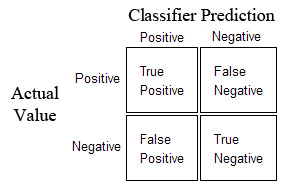

In [ ]:
feat_imp = pd.Series(trained_model.feature_importances_, index=X.columns)
feat_imp.nlargest(12).plot(kind='barh', figsize=(8,10))

Feature importance as per the model

### SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. 

In [ ]:
!pip install shap

In [ ]:
import shap
shap.initjs()

In [ ]:
shap_values = shap.TreeExplainer(trained_model.booster_).shap_values(X_train)

In [ ]:
shap.summary_plot(shap_values, X_train)

We can observe that attributes like Married, ApplicantIncome, Credit_History_Available, LoanAMount & CoapplicantIncome have high impact on the target variable. 

### In this notebook, we have done exploratory data analysis, feature importance, model building & interpreting the model attributes for improving the accuracy. This is to demonstrate some of the mandatory steps which are involved in building predictive models which are done manually. These steps can take days to complete. All these steps are automated in AutoAI feature in Watson Studio where we can create and deploy machine learning models in minutes. 